In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Gerekli kütüphanelerin import edilmesi ve verinin çekilmesi

### Yapılanlar hakkında

Burada veriyi çektiğimde öncesinde oluşturmuş olduğum "outlier_indices.csv" dosyasındaki outlier olarak tespit ettiğim gözlemleri veriden düşerek modeli eğittim. Bunun nedeni hem modelin başarımını arttırmak hem de modelin outlier olarak davrana gözlemler için yaptığı tahmini merak etmemdi.

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# Verileri yükleme
data = pd.read_csv("./data/selected_data/data.csv")
outliers = pd.read_csv("./data/selected_data/outlier_indices.csv")

data_cp = data.drop(list(outliers["Outlier_indeksler"]))

X = data_cp.drop('label', axis=1) 
y = data_cp['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model oluşturma

Burada, LightGBM sınıflandırıcı modelimizi GridSearchCV kullanarak hiperparametrelerini aramak için ayarlıyoruz. 

- `param_grid`: Aramak istediğimiz hiperparametrelerin değerlerini belirlediğimiz bir sözlük.
- `cv=5`: 5 katlı çapraz doğrulama kullanarak modelin performansını değerlendireceğimiz çapraz doğrulama stratejisi.
- `scoring='accuracy'`: GridSearchCV'nin en iyi modeli seçerken kullanacağı skorlama metriği.

GridSearchCV, belirtilen parametre aralıkları içinde farklı kombinasyonlar deneyerek en iyi hiperparametreleri bulur ve en iyi modeli seçer. Bu süreç tamamlandıktan sonra en iyi modeli kullanarak eğitim setindeki verileri kullanarak modeli eğitiyoruz.


In [3]:
model = lgb.LGBMClassifier(random_state=42)

param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 1679, number of used features: 90
[LightGBM] [Info] Start training from score -1.087360
[LightGBM] [Info] Start training from score -0.924664
[LightGBM] [Info] Start training from score -1.323395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 1679, number of used features: 90
[LightGBM] [Info] Start training from score -1.087360
[LightGBM] [Info] Start training from score -0.924664
[LightGBM] [Info] Start training from score -1.323395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002259 sec

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [20, 30, 40]},
             scoring='accuracy')

### En iyi parametreler ve doğruluk skoru

In [4]:
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk skoru:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Doğruluğu:", accuracy)

En iyi parametreler: {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 20}
En iyi doğruluk skoru: 0.7541697920218207
Test Doğruluğu: 0.7676190476190476


### Doğruluk tablosu oluşturma

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Tahmin Edilen')

Text(70.72222222222221, 0.5, 'Gerçek Değerler')

Text(0.5, 1.0, 'Doğruluk Tablosu')

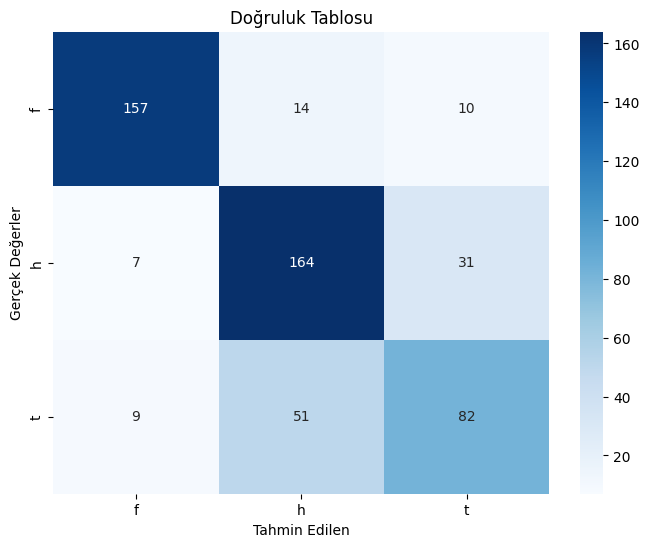

In [5]:
cm = confusion_matrix(y_test, y_pred)
labels = ['f', 'h', 't']
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değerler')
plt.title('Doğruluk Tablosu')
plt.show()

# Modeli outlier değerlere göre değerlendirelim

Bu bölümde, modelin performansını değerlendirirken eğitim verisinden çıkardığımız outlier değerlerini kullanıyoruz.

- İlk olarak, `X_cp` ve `y_cp` veri setini oluşturuyoruz. Burada, tüm verileri içeren `data` DataFrame'inden etiket sütununu düşürerek `X_cp`'yi ve yalnızca etiket sütununu seçerek `y_cp`'yi oluşturuyoruz.

- Ardından, en iyi modeli kullanarak outlier değerlerini tahmin ediyoruz. `X_cp` veri setinden sadece outlier indekslerine sahip satırları seçerek, bu satırların etiketlerini tahmin ediyoruz.

- Son olarak, tahmin edilen outlier etiketlerini gerçek outlier etiketleri ile karşılaştırarak doğruluk skorunu hesaplıyoruz ve bir doğruluk tablosu oluşturuyoruz. Bu tablo, outlier tahminlerinin gerçek değerlerle karşılaştırılmasını görselleştirir.


Test Doğruluğu: 0.58994708994709


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Tahmin Edilen')

Text(70.72222222222221, 0.5, 'Gerçek Değerler')

Text(0.5, 1.0, 'Doğruluk Tablosu')

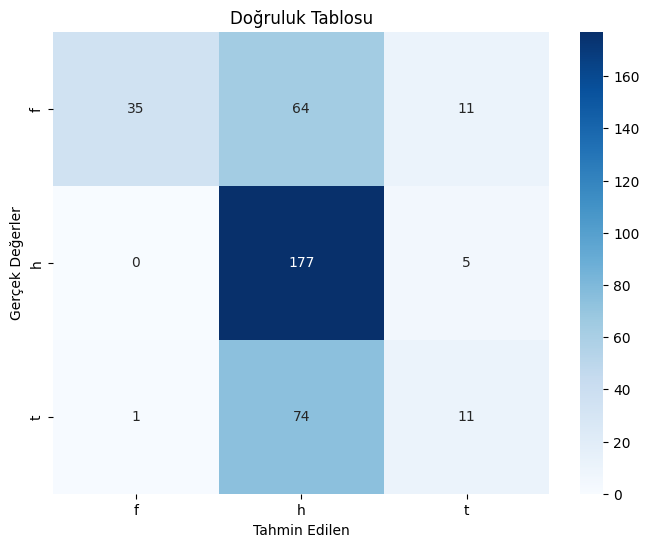

In [6]:
X_cp = data.drop('label', axis=1) 
y_cp = data['label']
y_pred_outliers = best_model.predict(X_cp.loc[list(outliers["Outlier_indeksler"])])
outlier_accuracy = accuracy_score(y_cp[outliers["Outlier_indeksler"]], y_pred_outliers)
print("Test Doğruluğu:", outlier_accuracy)

cm = confusion_matrix(y_cp[outliers["Outlier_indeksler"]], y_pred_outliers)
labels = ['f', 'h', 't']
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değerler')
plt.title('Doğruluk Tablosu')
plt.show()

# Sonuç 

Sonuç olarak, teknoloji ve finans sektörlerinde outlier olarak davranan değerleri modelimize verdiğimizde, tahmine göre:

- Finans (f) sektöründeki outlierların büyük çoğunluğu (64 tanesi) sağlık sektörü (h) gibi davranmaktadır.
- Teknoloji (t) sektöründeki outlierların büyük çoğunluğu (74 tanesi) sağlık sektörü (h) gibi davranmaktadır.

Ancak garip bir şekilde, normalde sağlık (h) sektöründeki outlier olarak bulduğumuz değerlerin, modelimize göre sağlık sektöründe olduğunu görüyoruz.